In [1]:
# for use with data from Raman tool "image scan" feature 


import pylab as py
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore', np.RankWarning)

def get_ratio(xdata, ydata, start_G_range, end_G_range, start_G_peak, start_2D_range, end_2D_range, start_2D_peak):
    
    x_np = np.array(xdata)
    y_np = np.array(ydata)

    # select G peak
    x_G = x_np[(np.argmax(x_np>start_G_range)):(np.argmax(x_np>end_G_range))]
    y_G = y_np[(np.argmax(x_np>start_G_range)):(np.argmax(x_np>end_G_range))]

    # select 2D peak
    x_2D = x_np[(np.argmax(x_np>start_2D_range)):(np.argmax(x_np>end_2D_range))]
    y_2D = y_np[(np.argmax(x_np>start_2D_range)):(np.argmax(x_np>end_2D_range))]



    # POLYNOMIAL FIT TO SPECTRUM

    # degree of polynomial fit
    degree_G = 10
    degree_2D = 10

    # calculate polynomial
    z_G = np.polyfit(x_G, y_G, degree_G)
    f_G = np.poly1d(z_G)
    z_2D = np.polyfit(x_2D, y_2D, degree_2D)
    f_2D = np.poly1d(z_2D)

    # calculate y values for polynomial
    y_G_poly = f_G(x_G)
    y_2D_poly = f_2D(x_2D)


    # derivatives
    import scipy.misc as sm
    derivs2_G = []
    for i in x_G:
        derivs2_G.append((sm.derivative(f_G, i, n=2)))
    derivs2_2D = [] 
    for i in x_2D:
        derivs2_2D.append((sm.derivative(f_2D, i, n=2)))



    # FIND LOCAL MAXIMA OF SECOND DERIVATIVE

    # fits a polynomial to 2nd derivative, finds maxima of that

    # degree of polynomial fit
    degree2_G = 10
    degree2_2D = 10

    # calculate polynomial
    z2_G = np.polyfit(x_G, derivs2_G, degree2_G)
    f2_G = np.poly1d(z2_G)
    z2_2D = np.polyfit(x_2D, derivs2_2D, degree_2D)
    f2_2D = np.poly1d(z2_2D)

    # calculate y values for polynomial
    y2_G = f2_G(x_G)
    y2_2D = f2_2D(x_2D)

    # find local maxima 
    from scipy.signal import argrelextrema

    # use start_peak to eliminate edge effects
    idx_G = np.argmax(x_G>start_G_peak)
    x_Gpeak = x_G[idx_G:]
    derivs2a_G = np.array(y2_G[idx_G:])

    idx_2D = np.argmax(x_2D>start_2D_peak)
    x_2Dpeak = x_2D[idx_2D:]
    derivs2a_2D = np.array(y2_2D[idx_2D:])

    # this is indexed from the start of x_G, x_2D
    maxs_G = argrelextrema(derivs2a_G, np.greater)
    start_idx_G = maxs_G[0][0] + idx_G
    end_idx_G = maxs_G[0][1] + idx_G
    start_G = x_G[start_idx_G]
    end_G = x_G[end_idx_G]

    maxs_2D = argrelextrema(derivs2a_2D, np.greater)
    start_idx_2D = maxs_2D[0][0] + idx_2D
    end_idx_2D = maxs_2D[0][1] + idx_2D
    start_2D = x_2D[start_idx_2D]
    end_2D = x_2D[end_idx_2D]




    # FIT CURVE TO BACKGROUND 

    # exclude peak
    x_G_no_peak = np.concatenate((x_G[:start_idx_G], x_G[end_idx_G:]))
    y_G_no_peak = np.concatenate((y_G[:start_idx_G], y_G[end_idx_G:]))

    x_2D_no_peak = np.concatenate((x_2D[:start_idx_2D], x_2D[end_idx_2D:]))
    y_2D_no_peak = np.concatenate((y_2D[:start_idx_2D], y_2D[end_idx_2D:]))

    # degree of polynomial fit to background
    degree3_G = 3
    degree3_2D = 3

    # calculate polynomial
    z3_G = np.polyfit(x_G_no_peak, y_G_no_peak, degree3_G)
    f3_G = np.poly1d(z3_G)

    z3_2D = np.polyfit(x_2D_no_peak, y_2D_no_peak, degree3_2D)
    f3_2D = np.poly1d(z3_2D)



    # SUBTRACT OUT BACKGROUND
    y_G_fixed = y_G - f3_G(x_G)
    y_2D_fixed = y_2D - f3_2D(x_2D)
    
    
    
    # CURVE FITTING
    from scipy.optimize import curve_fit
    from math import pi

    xdata_G = x_G
    ydata_G = y_G_fixed
    xdata_2D = x_2D
    ydata_2D = y_2D_fixed

    # initial parameters (guess - doesn't really matter)
    init_center_G = 1600
    init_width_G = 10
    init_amplitude_factor_G = 300

    init_center_2D = 2700
    init_width_2D = 10
    init_amplitude_factor_2D = 300

    init_params_G = [init_center_G, init_width_G, init_amplitude_factor_G]
    init_params_2D = [init_center_2D, init_width_2D, init_amplitude_factor_2D]

    # lorentzian peak function
    def lorentz(x, center, width, A):
        return ( A * (0.5 * width) / (pi * ( ((x - center) ** 2) + ((0.5 * width) ** 2) ) ))

    params_G, cov_G = curve_fit(lorentz, xdata_G, ydata_G, p0=init_params_G)
    height_G = params_G[2] * 2 / (pi * params_G[1])
    FWHM_G = params_G[1]

    params_2D, cov_2D = curve_fit(lorentz, xdata_2D, ydata_2D, p0=init_params_2D)
    height_2D = params_2D[2] * 2 / (pi * params_2D[1])
    FWHM_2D = params_2D[1]

    ratio = height_2D / height_G

    return(ratio)


In [24]:
path = 'C:\\Users\\abarrett.BNL\\Data\\2018.06.20\\ACS_6-8_layer_Gr_Cu\\'
yfile = path + '1 Scan_002_Spec.Data 1_F (Y-Axis).txt'
xfile = path + '1 Scan_002_Spec.Data 1_F (X-Axis).txt'

# load data
x = np.loadtxt(xfile)
y_temp = np.loadtxt(yfile)

# y is a list, each element of the list is a numpy array
# of the spectrum (y data only) of one pixel
y = np.split(y_temp, len(y_temp) / len(x))



In [25]:
ratios = [] 
for yspec in y:
    get_ratio(x, yspec, 1400, 1800, 1500, 2500, 2900, 2600)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
%run get_ratio.ipynb

In [26]:
len(y)

100

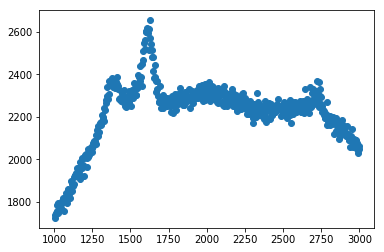

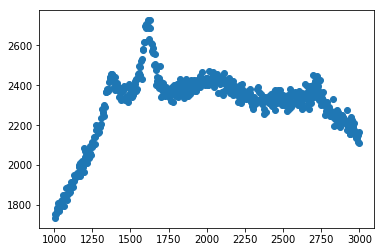

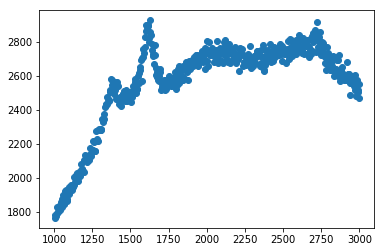

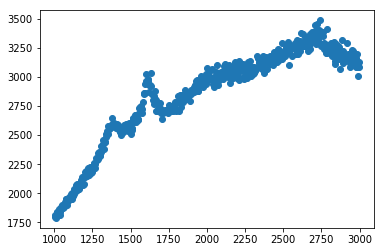

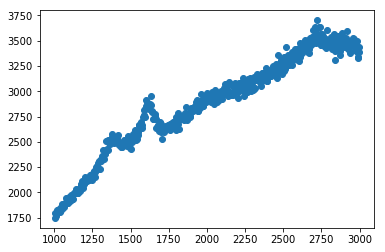

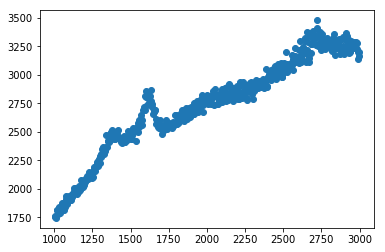

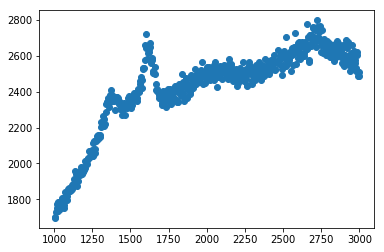

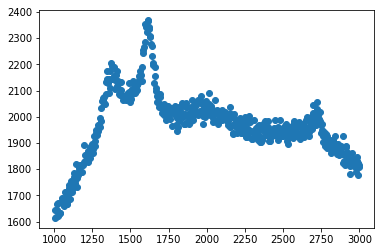

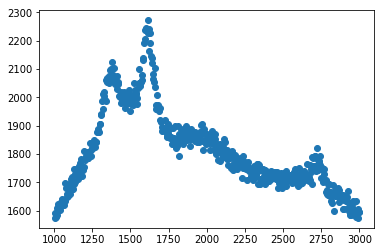

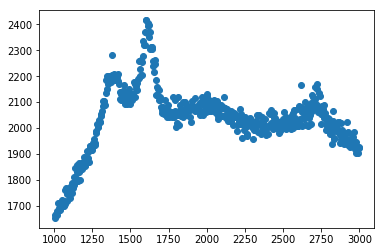

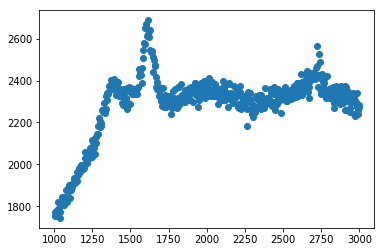

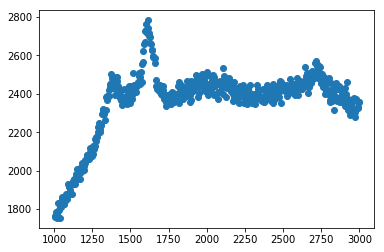

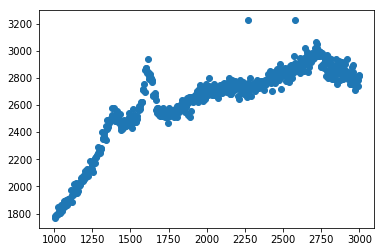

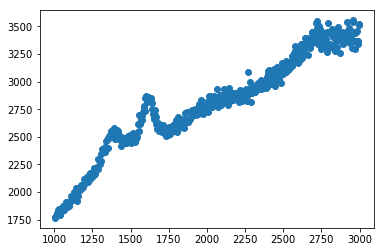

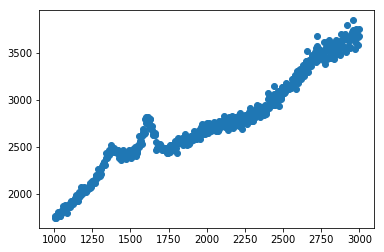

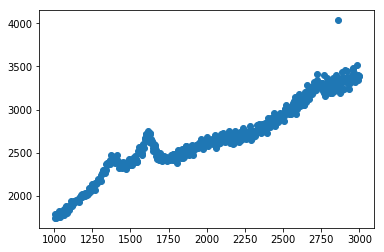

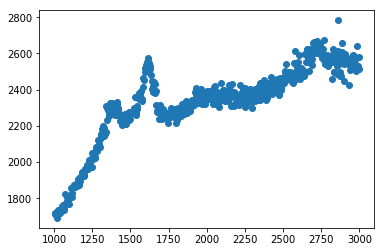

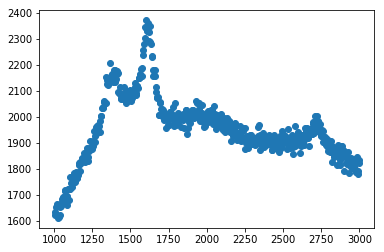

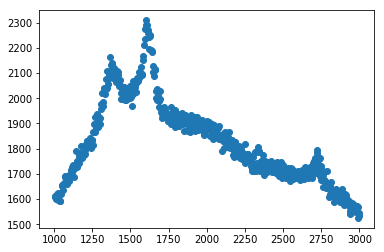

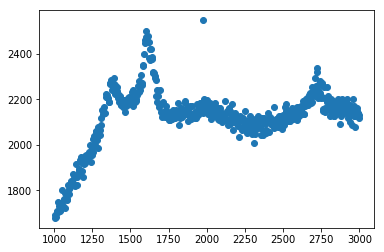

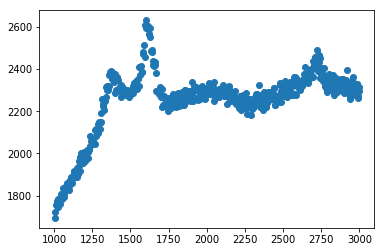

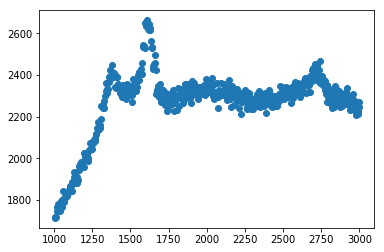

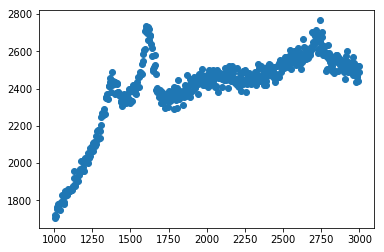

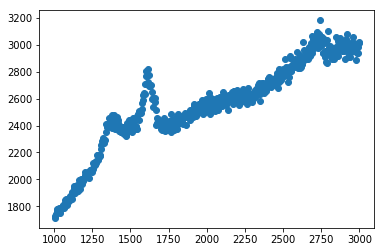

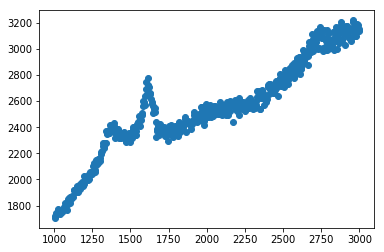

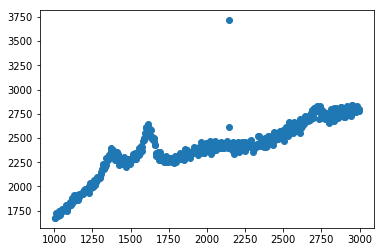

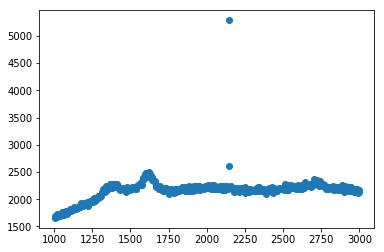

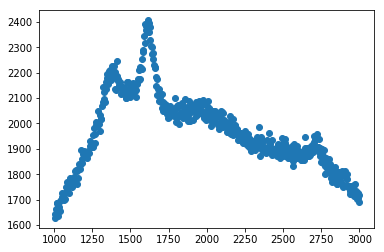

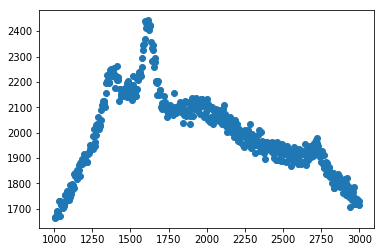

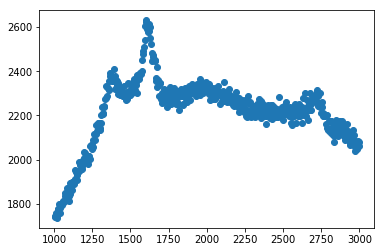

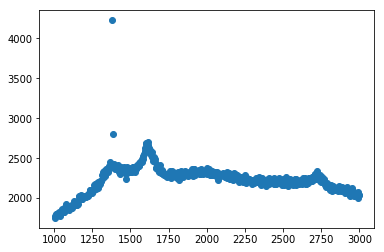

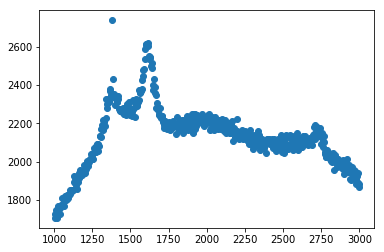

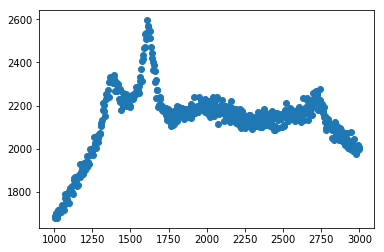

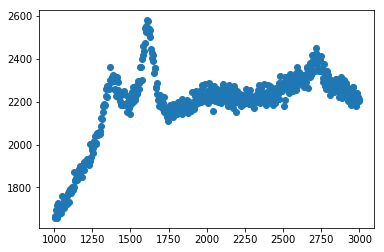

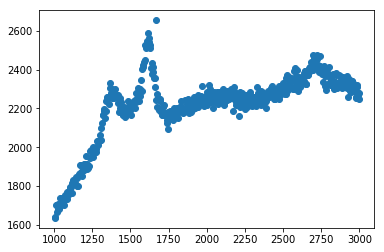

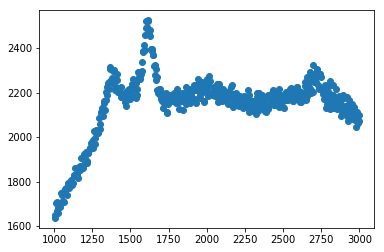

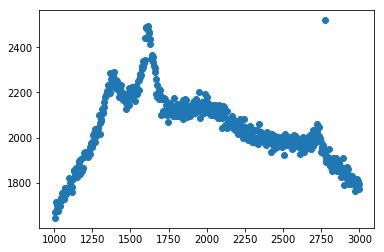

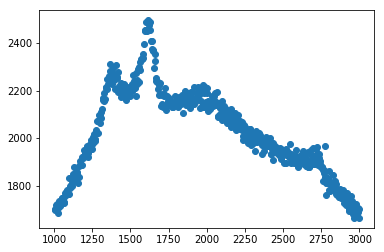

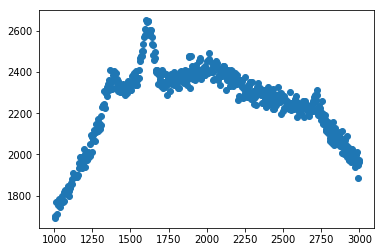

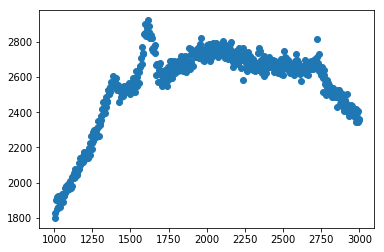

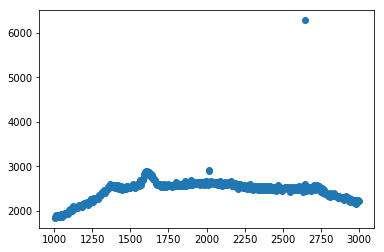

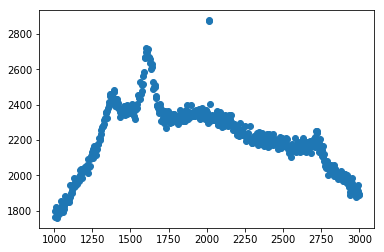

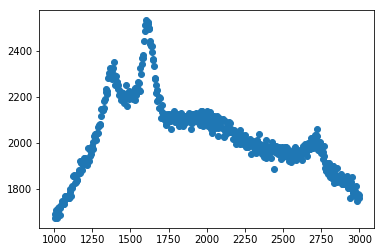

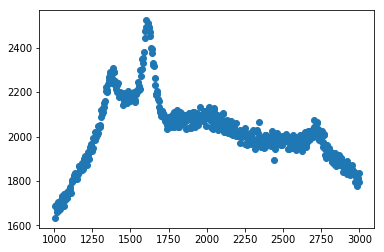

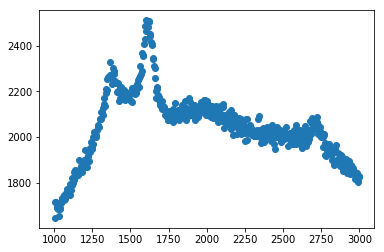

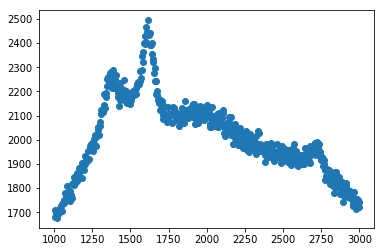

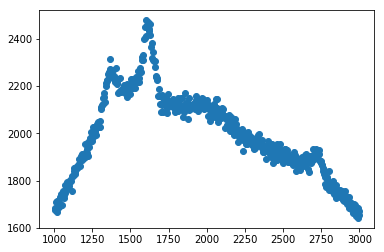

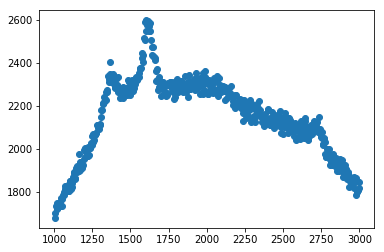

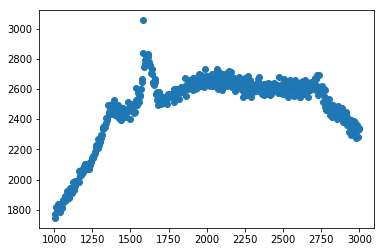

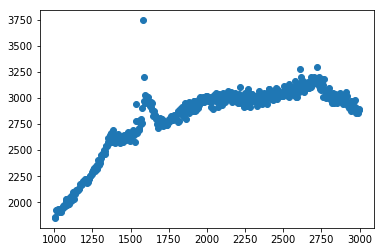

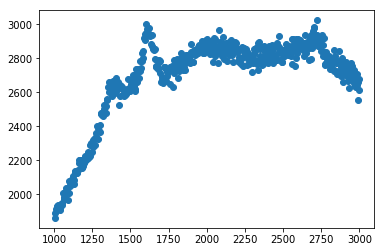

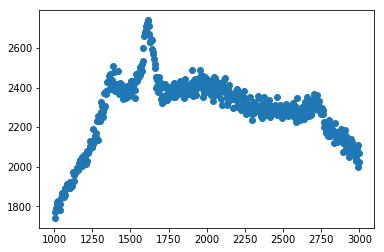

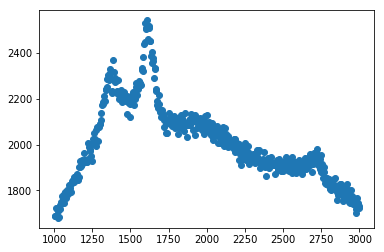

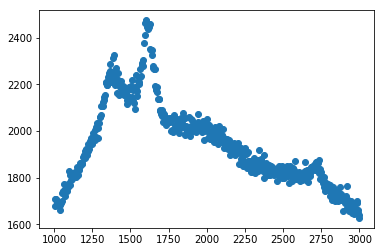

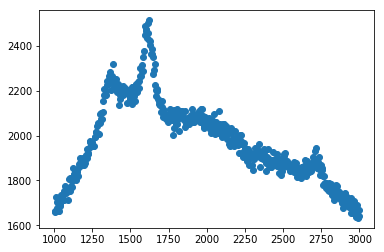

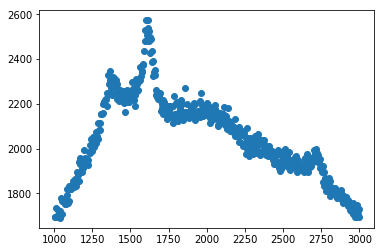

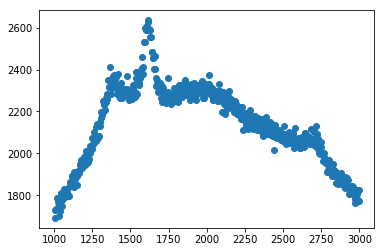

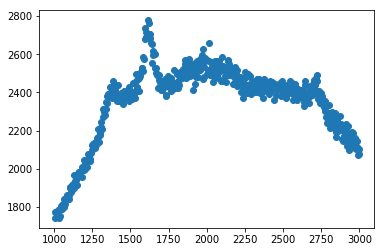

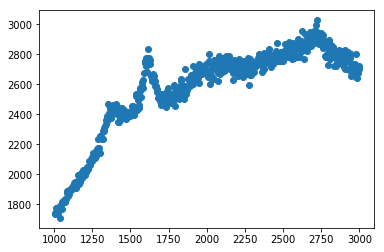

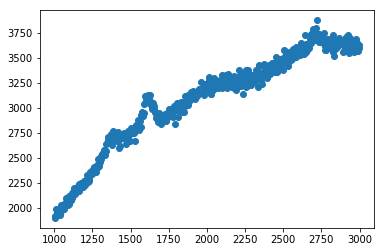

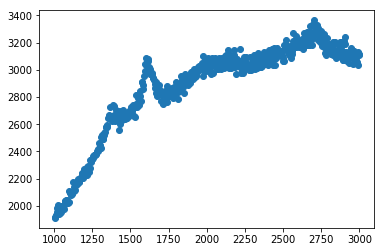

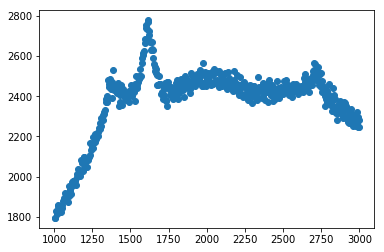

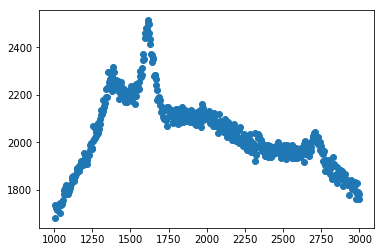

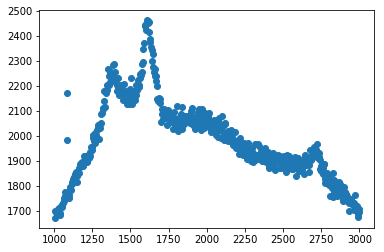

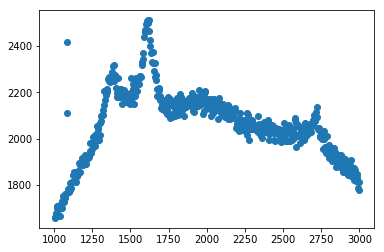

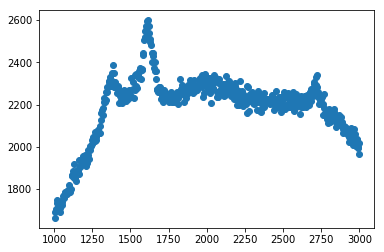

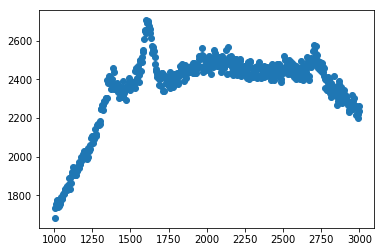

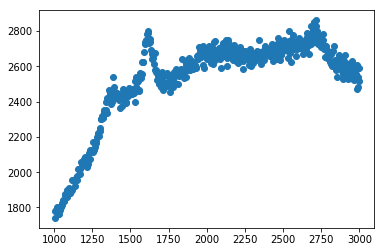

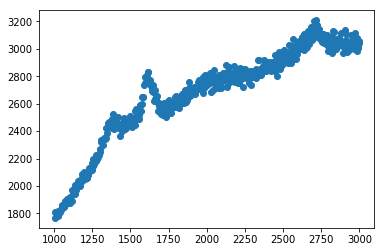

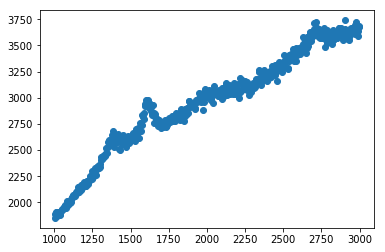

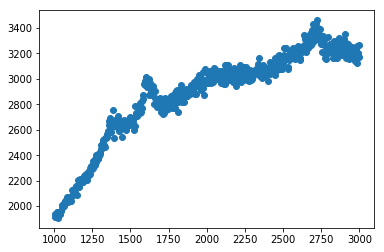

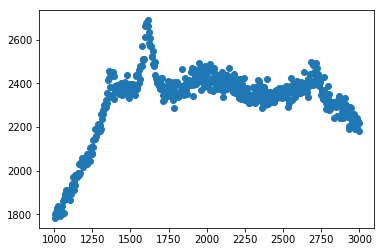

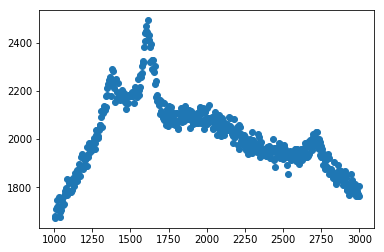

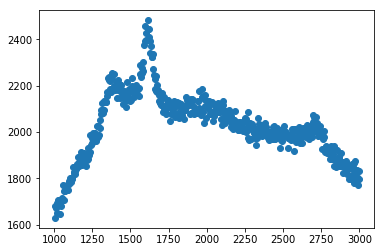

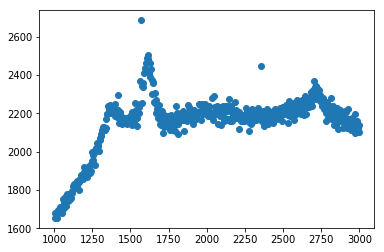

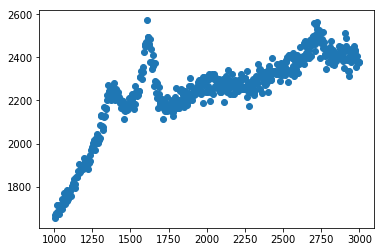

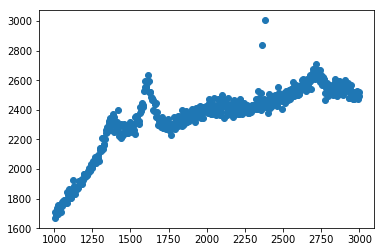

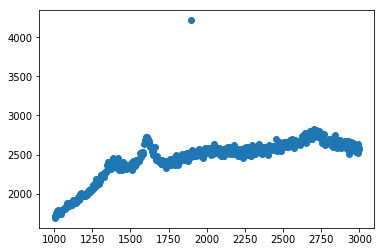

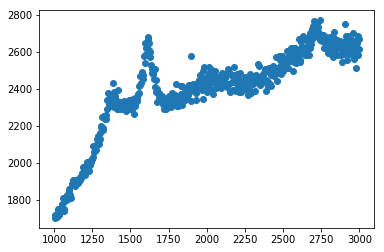

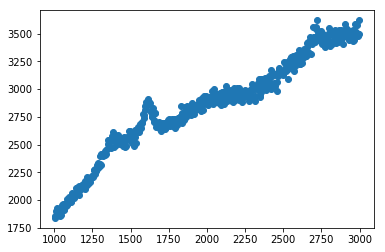

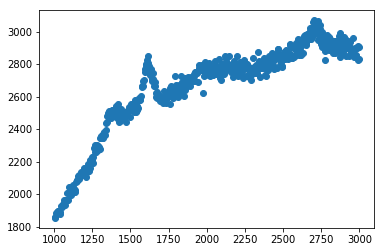

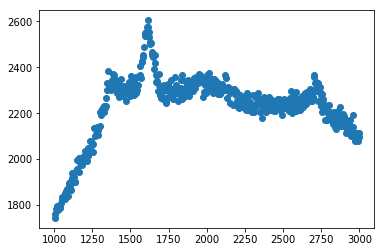

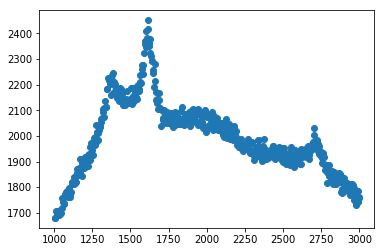

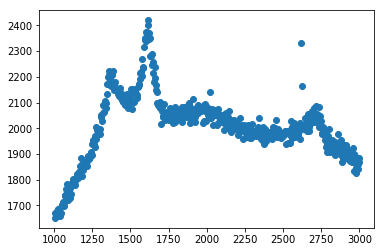

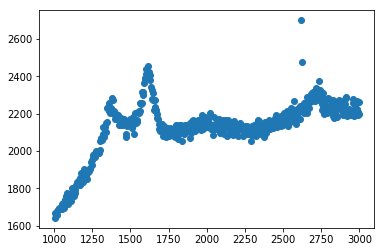

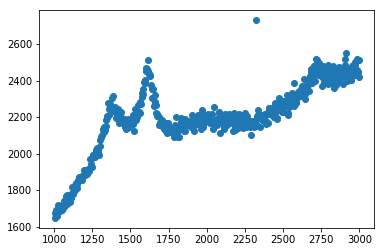

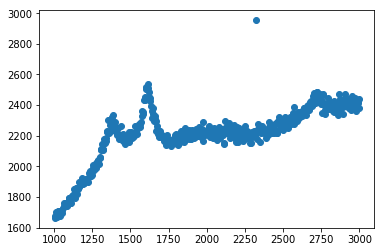

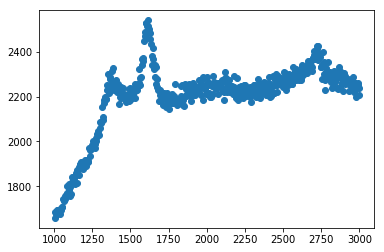

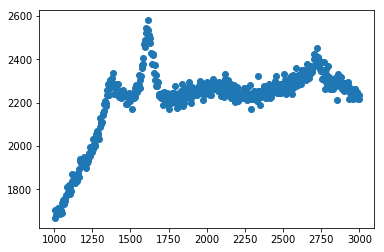

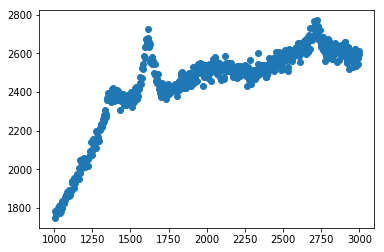

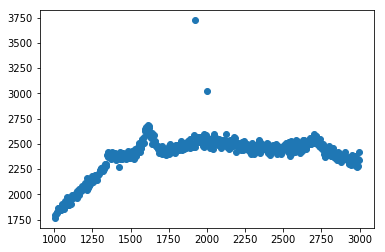

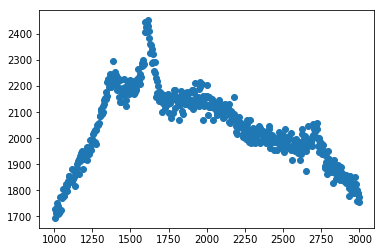

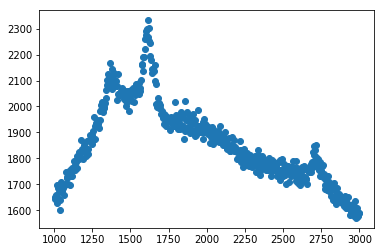

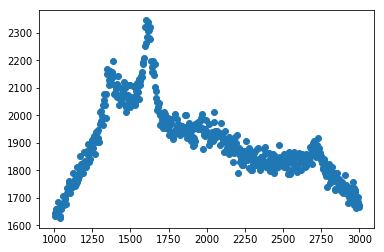

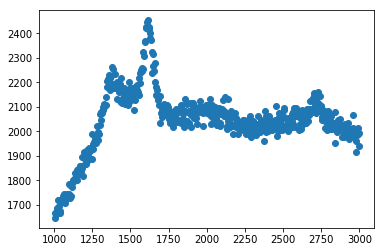

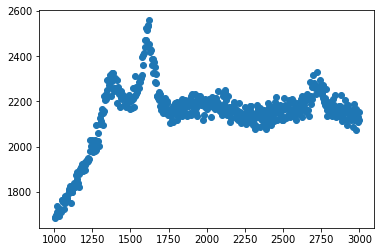

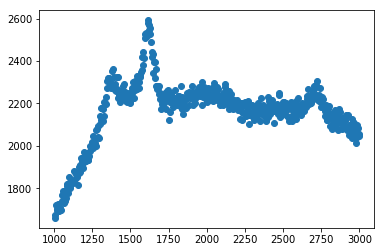

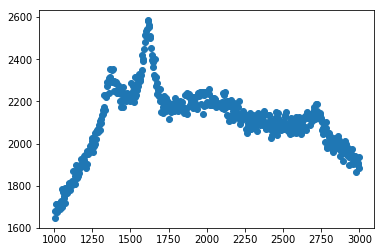

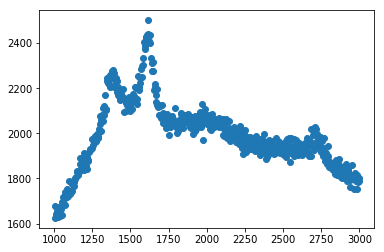

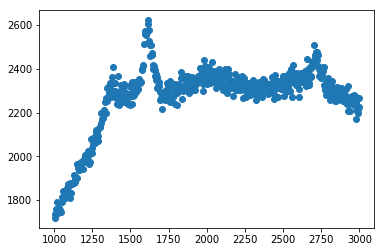

In [27]:
for i in range(100):
    plt.figure(0)
    # py.title('Spectrum')
    spec_start = np.argmax(x>1000)
    spec_end = np.argmax(x>3000)
    py.scatter(x[spec_start:spec_end],y[i][spec_start:spec_end])
    py.show()

In [30]:
ratios = [] 
i = 0
for yspec in y:
    get_ratio(x, yspec, 1400, 1800, 1425, 2500, 2900, 2550)
    i = i + 1

IndexError: index 1 is out of bounds for axis 0 with size 1

In [31]:
i

14

In [34]:
get_ratio_with_plots(x, y[14], 1400, 1800, 1425, 2500, 2900, 2500)

IndexError: index 1 is out of bounds for axis 0 with size 1